## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [ ]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = "".join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
tokens = sorted(set(text))
print(f"Number of unique tokens: {len(tokens)}")
print(tokens)

Number of unique tokens: 38
['\n', ' ', '!', "'", '(', ')', ',', '-', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
# dict <index>:<char>
idx_to_token = {i: token for i, token in enumerate(tokens)}

# dict <char>:<index>
token_to_idx = {token: i for i, token in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from IPython.display import clear_output

# Определение архитектуры
class CharRNN(nn.Module):
    def __init__(self, num_tokens, emb_size=64, rnn_num_units=128):
        super(self.__class__, self).__init__()
        self.num_tokens = num_tokens
        self.rnn_num_units = rnn_num_units

        # Слой эмбеддинга
        self.emb = nn.Embedding(num_tokens, emb_size)

        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)

        # Выходной слой
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, hidden=None):
        embed = self.emb(x)

        # h_seq: выходы на каждом шаге, h_last: последнее скрытое состояние
        h_seq, h_last = self.rnn(embed, hidden)

        logits = self.hid_to_logits(h_seq)

        return logits, h_last

    def initial_state(self, batch_size):
        return torch.zeros(1, batch_size, self.rnn_num_units, device=device)

# Функция для получения  батча
def get_batch(text, batch_size=64, seq_len=100):
    start_idxs = np.random.randint(0, len(text) - seq_len - 1, size=batch_size)

    input_seqs = []
    target_seqs = []

    for i in start_idxs:
        chunk_in = text[i : i + seq_len]
        chunk_out = text[i+1 : i + seq_len + 1]

        input_seqs.append([token_to_idx[c] for c in chunk_in])
        target_seqs.append([token_to_idx[c] for c in chunk_out])

    return torch.tensor(input_seqs, dtype=torch.long), torch.tensor(target_seqs, dtype=torch.long)

# Инициализация и Обучение
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Гиперпараметры
num_tokens = len(tokens)
model = CharRNN(num_tokens, emb_size=64, rnn_num_units=256).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

history = []
num_iterations = 2000

for i in range(num_iterations):
    batch_ix, batch_next = get_batch(text, batch_size=128, seq_len=60)
    batch_ix = batch_ix.to(device)
    batch_next = batch_next.to(device)

    logits, _ = model(batch_ix)

    loss = loss_func(logits.permute(0, 2, 1), batch_next)

    opt.zero_grad()
    loss.backward()
    opt.step()

    history.append(loss.item())

    if (i+1) % 100 == 0:
        clear_output(True)
        print(f"Iter: {i+1}, Loss: {loss.item():.4f}")



char_rnn = model

Iter: 2000, Loss: 1.0324


**Plot** the loss function (axis X: number of epochs, axis Y: loss function).

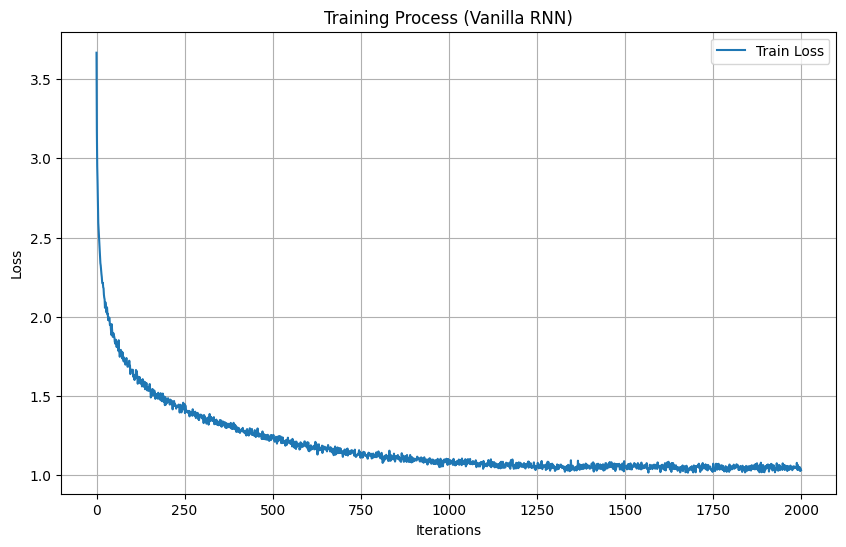

In [ ]:
# Your plot code here
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history, label='Train Loss')
plt.title('Training Process (Vanilla RNN)')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
def generate_sample(char_rnn, seed_phrase=' Hello', max_length=200, temperature=1.0):

    char_rnn.eval()

    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.long).to(device)

    hid_state = char_rnn.initial_state(batch_size=1)

    with torch.no_grad():
        for i in range(len(seed_phrase) - 1):
            out, hid_state = char_rnn(x_sequence[:, i].unsqueeze(1), hid_state)

    for _ in range(max_length - len(seed_phrase)):
        with torch.no_grad():
            out, hid_state = char_rnn(x_sequence[:, -1].unsqueeze(1), hid_state)

            p_next = F.softmax(out / temperature, dim=-1).data.cpu().numpy()

            p_next = p_next.flatten()


            p_next = p_next / p_next.sum()

            next_ix = np.random.choice(len(tokens), p=p_next)

            next_ix = torch.tensor([[next_ix]], dtype=torch.long).to(device)
            x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0]])

In [ ]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))


print("--- Temperature 0.2 (Консервативно) ---")
print(generate_sample(char_rnn, seed_phrase='shall i compare thee to a summer\'s day?\n', temperature=0.2))

print("\n--- Temperature 0.5 (Сбалансированно) ---")
print(generate_sample(char_rnn, seed_phrase='shall i compare thee to a summer\'s day?\n', temperature=0.5))

print("\n--- Temperature 1.0 (Рискованно) ---")
print(generate_sample(char_rnn, seed_phrase='shall i compare thee to a summer\'s day?\n', temperature=1.0))

--- Temperature 0.2 (Консервативно) ---
shall i compare thee to a summer's day?
  when i am so such seem worms, in despession follow that which i am not the sun a famon's face shall in the world will with their far love, thou art for my sig

--- Temperature 0.5 (Сбалансированно) ---
shall i compare thee to a summer's day?
  who like star thee,
    and they thou art as the will;
  nor so succeeding;
  or when thou mayst thou art as the time that i have sworn the greating crime.
  

--- Temperature 1.0 (Рискованно) ---
shall i compare thee to a summer's day?
  o! none wretched errors to prof,
  and ruin art on percum'd be time do abuse,
  sincain?
  even but purpose,
  have, being full of my pain.

  xcviii

  how c


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

LSTM Iter: 2000, Loss: 0.5189


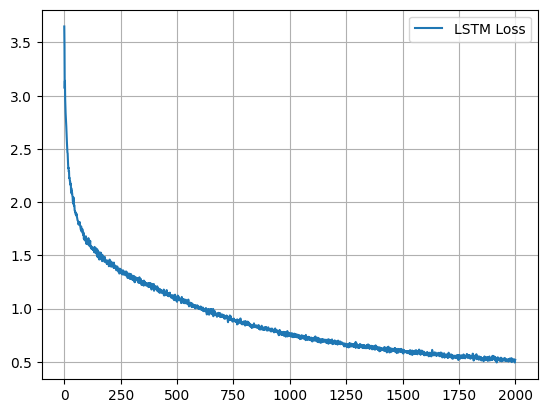

In [ ]:
# Your beautiful code here

class CharLSTM(nn.Module):
    def __init__(self, num_tokens, emb_size=64, rnn_num_units=128):
        super(self.__class__, self).__init__()
        self.num_tokens = num_tokens
        self.rnn_num_units = rnn_num_units

        self.emb = nn.Embedding(num_tokens, emb_size)

        self.lstm = nn.LSTM(emb_size, rnn_num_units, batch_first=True)

        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, hidden=None):
        embed = self.emb(x)

        output, hidden = self.lstm(embed, hidden)

        logits = self.hid_to_logits(output)
        return logits, hidden

    def initial_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.rnn_num_units, device=device),
                torch.zeros(1, batch_size, self.rnn_num_units, device=device))


model_lstm = CharLSTM(num_tokens, emb_size=64, rnn_num_units=256).to(device)
opt = torch.optim.Adam(model_lstm.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

history_lstm = []
num_iterations = 2000

for i in range(num_iterations):
    batch_ix, batch_next = get_batch(text, batch_size=128, seq_len=60)
    batch_ix = batch_ix.to(device)
    batch_next = batch_next.to(device)

    # Прямой проход
    logits, _ = model_lstm(batch_ix)

    loss = loss_func(logits.permute(0, 2, 1), batch_next)

    # Обратный проход
    opt.zero_grad()
    loss.backward()
    opt.step()

    history_lstm.append(loss.item())

    # Визуализация прогресса
    if (i+1) % 100 == 0:
        clear_output(True)
        print(f"LSTM Iter: {i+1}, Loss: {loss.item():.4f}")
        plt.plot(history_lstm, label='LSTM Loss')
        plt.legend()
        plt.grid()
        plt.show()


char_rnn = model_lstm

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
# Text generation with different temperature values here
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]
seed_phrase = "shall i compare thee to a summer's day?\n"

print(f"Start phrase: {seed_phrase.strip()}")

for t in temperatures:
    print(f"\n{'='*30}")
    print(f" Temperature: {t}")
    print(f"{'='*30}")
    try:
        generated_text = generate_sample(char_rnn, seed_phrase=seed_phrase, max_length=300, temperature=t)
        print(generated_text)
    except Exception as e:
        print(f"Error generating text: {e}")

Start phrase: shall i compare thee to a summer's day?

 Temperature: 0.1
shall i compare thee to a summer's day?
  thou art the fairest and most precious jewel.
  yet, in gualting hear, which i will not be free,
  for thou art all the first conceit of this will,
  for thought in the breath that from my song.

  xiii

  o! that you were your self here live,
  and proud of

 Temperature: 0.2
shall i compare thee to a summer's day?
  thou art the fairest and most proud of the spite of former days,
    to give full part, that putt'st forth all to use,
  and sue a friend came debtor for my sake
  roses of sweet silent love hath thee did prove,
    to this false part of me to you,
  though 

 Temperature: 0.5
shall i compare thee to a summer's day?
  thou betraying me, i do be woman poor rime,
  while he insults o'er dull and surfeit faithers wake away.
  now see what thou deserv'st alone.
  o am to the windes from my forgetfed, which i then do not be so trust;
  that in thy beauty's vein do

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here


save_path = 'shakespeare_lstm.pth'


torch.save(char_rnn.state_dict(), save_path)
print(f"Model weights saved to {save_path}")


loaded_model = CharLSTM(num_tokens=len(tokens), emb_size=64, rnn_num_units=256).to(device)

loaded_model.load_state_dict(torch.load(save_path, map_location=device))

loaded_model.eval()

print("\nGenerated text from the loaded model:")
print(generate_sample(loaded_model, seed_phrase='love is ', temperature=0.5))

Model weights saved to shakespeare_lstm.pth
Model loaded successfully!

Generated text from the loaded model:
love is better pass ure thou gav'st it, else in thee did i conquest of your fair being strange;
  they are the ground;
  book with me not to show my wit:
  duty so great, which now at brow,
  for i, m


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)